In [9]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

### Library

In [37]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler

import renom as rm
from renom.optimizer import Adam, Adagrad
from renom.cuda import set_cuda_active
# if you would like to use GPU, set True, otherwise you should be set to False
set_cuda_active(False)

In [11]:
def create_dataset(data, look_back, pred_length):
    exp, target = [], []
    for i in range(len(data) - look_back - pred_length):
        exp.append(data[i : i+look_back, :])
        target.append(data[i + look_back : i + look_back + pred_length, 9].T[0])
        
    n_features = np.array(exp).shape[2]
    exp = np.reshape(np.array(exp), [-1, look_back, n_features])
    target = np.reshape(np.array(target), [-1, 1])
    return exp, target

In [12]:
def create_class_dataset(data, look_back, pred_length, class_num):
    exp, target = [], []
    for i in range(len(data) - look_back - pred_length):
        exp.append(data[i : i+look_back, :])
        target.append(data[i + look_back : i + look_back + pred_length, 32:].T)
        
    n_features = np.array(exp).shape[2]
    exp = np.reshape(np.array(exp), [-1, look_back, n_features])
    target = np.reshape(np.array(target), [-1, class_num])
    return exp, target

In [13]:
def split_data(X, y, test_size=0.1):
    pos = int(round(len(X) * (1-test_size)))
    X_train, y_train = X[:pos], y[:pos]
    X_test, y_test = X[pos:], y[pos:]
    return X_train, y_train, X_test, y_test, pos

In [14]:
gran = 'H1'

In [15]:
# with open('../intermediate_data/prep_data_{}.pickle'.format(gran), mode='rb') as f:
#     df = pickle.load(f)

In [16]:
with open('../intermediate_data/prep_class_data_{}.pickle'.format(gran), mode='rb') as f:
    df = pickle.load(f)

In [17]:
df_std = df.copy()
stds, means = [], []
cols = []
for col in df:
    if (col != 'up') & (col != 'down') & (col != 'nochange'):
        std = df[col].std()
        mean = df[col].mean()
        df_std[col] = (df[col] - mean) / std
        stds.append(std)
        means.append(mean)
data = np.array(df_std)

In [18]:
look_back = 10
pred_length = 1
class_num = 3
# X, y = create_dataset(data, look_back, pred_length)
X, y = create_class_dataset(data, look_back, pred_length, class_num)

In [19]:
X_train, y_train, X_test, y_test, pos = split_data(X, y)

In [20]:
sequential = rm.Sequential([
    rm.Lstm(30),
    rm.Dropout(0.2),
    rm.Lstm(20),
    rm.Dropout(0.2),
#     rm.Dense(pred_length)
    rm.Dense(class_num)
])

In [21]:
batch_size = 1024
epoch = 1000
N = len(X_train)
T = X_train.shape[1]

learning_curve = []
test_learning_curve = []
optimizer = Adagrad()
for i in range(epoch):
    loss = 0
    test_loss = 0
    perm = np.random.permutation(N)
    for j in range(N//batch_size):
        train_batch = X_train[perm[j*batch_size : (j+1)*batch_size]]
        response_batch = y_train[perm[j*batch_size : (j+1)*batch_size]]
        l = 0
        with sequential.train():
            for t in range(T):
                z = sequential(train_batch[:, t, :])
                l = rm.softmax_cross_entropy(z, response_batch)
            sequential.truncate()
        l.grad().update(optimizer)
        loss += l.as_ndarray()
    loss = loss / (N // batch_size)
    l_test = 0
    for t in range(T):
        z = sequential(X_test[:, t, :])
        l_test = rm.softmax_cross_entropy(z, y_test)
    sequential.truncate()
    test_loss += l_test.as_ndarray()
    if i % 10 == 0:
        print("epoch:{:04d} loss:{:.5f} test_loss:{:.5f}".format(i, loss, test_loss))
    learning_curve.append(loss)
    test_learning_curve.append(test_loss)

epoch:0000 loss:0.79510 test_loss:0.71979
epoch:0010 loss:0.75453 test_loss:0.70637
epoch:0020 loss:0.75166 test_loss:0.70914
epoch:0030 loss:0.74933 test_loss:0.70713
epoch:0040 loss:0.74788 test_loss:0.70891
epoch:0050 loss:0.74672 test_loss:0.70767
epoch:0060 loss:0.74589 test_loss:0.70893
epoch:0070 loss:0.74419 test_loss:0.70591
epoch:0080 loss:0.74420 test_loss:0.70439
epoch:0090 loss:0.74312 test_loss:0.70342
epoch:0100 loss:0.74281 test_loss:0.70568
epoch:0110 loss:0.74241 test_loss:0.70361
epoch:0120 loss:0.74159 test_loss:0.70271
epoch:0130 loss:0.74136 test_loss:0.70362
epoch:0140 loss:0.74167 test_loss:0.70351
epoch:0150 loss:0.74060 test_loss:0.70599
epoch:0160 loss:0.74050 test_loss:0.70425
epoch:0170 loss:0.73991 test_loss:0.70243
epoch:0180 loss:0.74024 test_loss:0.70699
epoch:0190 loss:0.74059 test_loss:0.70232
epoch:0200 loss:0.73940 test_loss:0.70578
epoch:0210 loss:0.73912 test_loss:0.70531
epoch:0220 loss:0.73881 test_loss:0.70486
epoch:0230 loss:0.73872 test_loss:

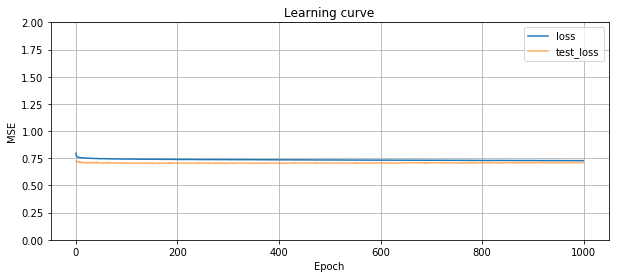

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(learning_curve, label='loss')
plt.plot(test_learning_curve, label='test_loss', alpha=0.6)
plt.title('Learning curve')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.ylim(0, 2)
plt.legend()
plt.grid()

In [25]:
# predict test value
for t in range(T):
    y_test_pred = sequential(X_test[:, t, :])
sequential.truncate()

In [27]:
# train value
for t in range(T):
    y_train_pred = sequential(X_train[:, t, :])
sequential.truncate()

In [43]:
train_pred = np.array(np.argmax(y_train_pred, axis=1))
test_pred = np.array(np.argmax(y_test_pred, axis=1))

In [36]:
train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

In [44]:
print(confusion_matrix(test_true, test_pred))
print(classification_report(test_true, test_pred))

[[   3    0  859]
 [   2    0  866]
 [   3    2 5557]]
             precision    recall  f1-score   support

          0       0.38      0.00      0.01       862
          1       0.00      0.00      0.00       868
          2       0.76      1.00      0.87      5562

avg / total       0.63      0.76      0.66      7292



In [46]:
sequential.save("../class_model/lstm_{}_{}.h5".format(gran, look_back))

In [47]:
with open('../class_model/std_scaler_{}.pickle'.format(gran), mode='wb') as f:
    pickle.dump(stds, f)

In [48]:
with open('../class_model/mean_scaler_{}.pickle'.format(gran), mode='wb') as f:
    pickle.dump(means, f)